<a href="https://colab.research.google.com/github/efandresena/AIMS-Course/blob/main/mirindraf_mlas_practical_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practical 2 : Model with biases only

### Split Dataset

In [82]:
import random

class Dataset:
    def __init__(self):
        self.userId_to_idx = {}
        self.idx_to_userId = []
        self._data_by_user = []

        self.movieId_to_idx = {}
        self.idx_to_movieId = []
        self._data_by_movie = []

    @property
    def usr_size(self):
        return len(self.idx_to_userId)

    @property
    def movie_size(self):
        return len(self.idx_to_movieId)

    def is_old_user(self, userId):
        return userId in self.userId_to_idx

    def is_old_movie(self, movieId):
        return movieId in self.movieId_to_idx

    def fetch(self, userId, movieId, rating_value, train=True):
        # Ensure user exists
        if not self.is_old_user(userId):
            user_pos = len(self.idx_to_userId)
            self.userId_to_idx[userId] = user_pos
            self.idx_to_userId.append(userId)
            self._data_by_user.append([])
        else:
            user_pos = self.userId_to_idx[userId]

        # Ensure movie exists
        if not self.is_old_movie(movieId):
            movie_pos = len(self.idx_to_movieId)
            self.movieId_to_idx[movieId] = movie_pos
            self.idx_to_movieId.append(movieId)
            self._data_by_movie.append([])
        else:
            movie_pos = self.movieId_to_idx[movieId]

        # Only add rating if this is train/test actual dataset
        if train is not None:
            self._data_by_user[user_pos].append((movie_pos, rating_value))
            self._data_by_movie[movie_pos].append((user_pos, rating_value))

    def __repr__(self):
        return (f"Dataset(users={self.usr_size}, movies={self.movie_size}, "
                f"ratings={sum(len(r) for r in self._data_by_user)})")




In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

# Read the file
link = "/content/ml-latest-small/ratings.csv"


In [83]:


import random
# --- Example streaming split ---
train = Dataset()
test = Dataset()
test_ratio = 0.2

with open(link, 'r') as file:
    next(file)  # skip header
    for i, line in enumerate(file):
        # if i >= 202:  # test smaller subset
        #     break
        userId, movieId, rating, _ = line.strip().split(',')
        rating = float(rating)

        # Random split per rating
        if random.random() < test_ratio:
            test.fetch(userId, movieId, rating, train=True)
            train.fetch(userId, movieId, rating, train=None)  # ensure alignment
        else:
            train.fetch(userId, movieId, rating, train=True)
            test.fetch(userId, movieId, rating, train=None)
# --- Print first 20 ratings per user/movie ---
def inspect_dataset(ds, name):
    print(f"\n{name}: {ds}")
    print("First 20 ratings per user:")
    for u_idx, ratings in enumerate(ds._data_by_user[:]):
        print(f" User {ds.idx_to_userId[u_idx]}: {ratings[:]}")
    print("\nFirst 20 ratings per movie:")
    for m_idx, ratings in enumerate(ds._data_by_movie[:]):
        print(f" Movie {ds.idx_to_movieId[m_idx]}: {ratings[:]}")


# inspect_dataset(train, "Train set")
# inspect_dataset(test, "Test set")



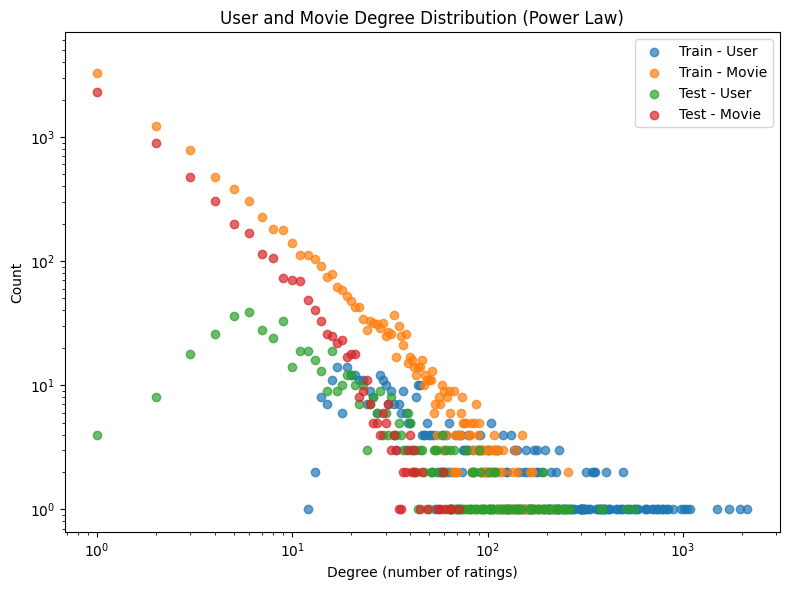

In [84]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

for dataset, name in [(train, "Train"), (test, "Test")]:
    user_degree = [len(user) for user in dataset._data_by_user]
    movie_degree = [len(movie) for movie in dataset._data_by_movie]

    unique_u, counts_u = np.unique(user_degree, return_counts=True)
    unique_m, counts_m = np.unique(movie_degree, return_counts=True)

    # Plot user and movie degree distributions
    ax.scatter(unique_u, counts_u, label=f'{name} - User', alpha=0.7)
    ax.scatter(unique_m, counts_m, label=f'{name} - Movie', alpha=0.7)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title('User and Movie Degree Distribution (Power Law)')
ax.set_xlabel('Degree (number of ratings)')
ax.set_ylabel('Count')
ax.legend()
plt.tight_layout()
plt.savefig("power_law.pdf")
plt.show()


### Model with biases only

In [85]:
data = Dataset()
with open(link, 'r') as file:
    next(file)  # skip header
    for i, line in enumerate(file):
        # if i >= 202:  # test smaller subset
        #     break
        userId, movieId, rating, _ = line.strip().split(',')
        rating = float(rating)
        data.fetch(userId, movieId, rating, train=True)


In [113]:
# Using train and dataset size :

lamda = 0.5  # regularization
gamma = 0.5  # learning rate
M = len(train._data_by_user)
N = len(train._data_by_movie)
user_biases = np.zeros((M))
item_biases = np.zeros((N))

# --- compute metrics ---
def compute_metrics(dataset):
    sq_err = 0.0
    count = 0
    for m, user_row in enumerate(dataset._data_by_user):
        for n, r in user_row:
            pred = user_biases[m] + item_biases[n]
            sq_err += (r - pred) ** 2
            count += 1
    loss = 0.5 * (sq_err / count)
    rmse = np.sqrt(sq_err / count)
    return loss, rmse

In [116]:
loss_train, loss_test = [], []
rmse_train, rmse_test = [], []
E = 20

for epoch in range(E):
    # --- update user biases ---
    for m in range(M):
        bias_sum = 0.0
        for (n, r) in train._data_by_user[m]:
            bias_sum += (r - item_biases[n])
        item_counter = len(train._data_by_user[m])
        if item_counter > 0:
            user_biases[m] =  bias_sum / (item_counter + lamda)

    # --- update item biases ---
    for n in range(N):
        bias_sum = 0.0
        for (m, r) in train._data_by_movie[n]:
            bias_sum += (r - user_biases[m])
        user_counter = len(train._data_by_movie[n])
        if user_counter > 0:
            item_biases[n] =  bias_sum / (user_counter + lamda)

    # --- compute metrics ---
    l_train, r_train = compute_metrics(train)
    l_test, r_test = compute_metrics(test)

    loss_train.append(l_train)
    loss_test.append(l_test)
    rmse_train.append(r_train)
    rmse_test.append(r_test)





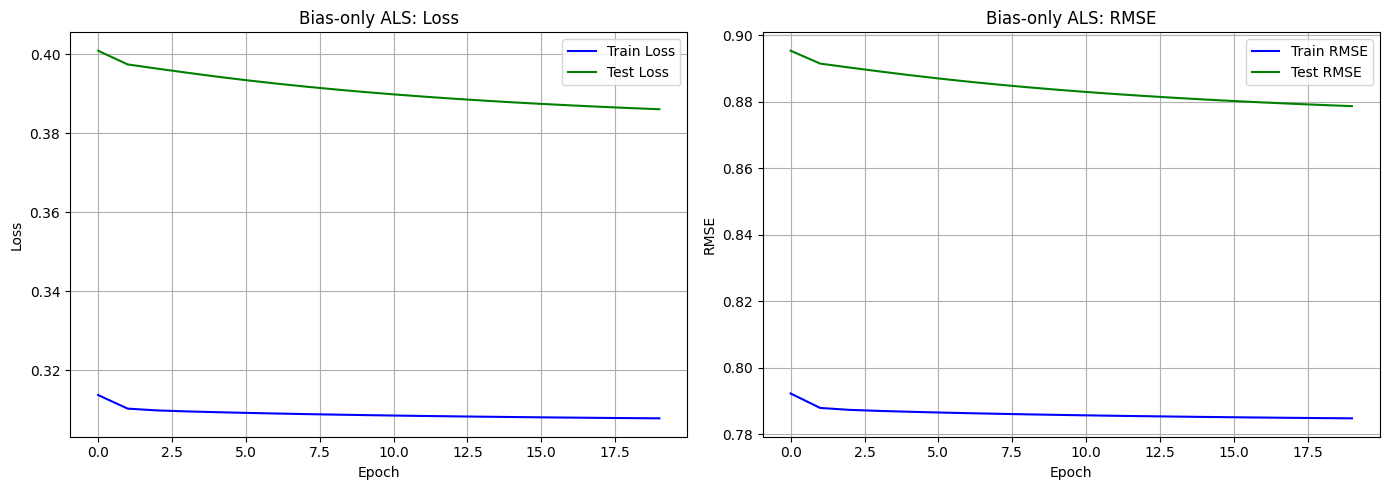

In [117]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- Loss plot ---
ax1.plot(loss_train, label="Train Loss", color='blue')
ax1.plot(loss_test, label="Test Loss", color='green')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Bias-only ALS: Loss")
ax1.legend()
ax1.grid(True)

# --- RMSE plot ---
ax2.plot(rmse_train, label="Train RMSE", color='blue')
ax2.plot(rmse_test, label="Test RMSE", color='green')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("RMSE")
ax2.set_title("Bias-only ALS: RMSE")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [89]:
def check_rating_consistency(dataset, user_idx, movie_idx):
    """
    Check that the rating for user_idx and movie_idx is the same in both
    _data_by_user and _data_by_movie structures.

    Returns:
        r_user: rating from _data_by_user
        r_movie: rating from _data_by_movie
        consistent: True if they match, False otherwise
    """
    r_user = None
    r_movie = None

    # Check _data_by_user
    for m, r in dataset._data_by_user[user_idx]:
        if m == movie_idx:
            r_user = r
            break

    # Check _data_by_movie
    for u, r in dataset._data_by_movie[movie_idx]:
        if u == user_idx:
            r_movie = r
            break

    consistent = r_user == r_movie
    return r_user, r_movie, consistent


In [99]:
for m,n in enumerate(range(50)):
  print(check_rating_consistency(data, m,m))

(4.0, 4.0, True)
(None, None, True)
(None, None, True)
(2.0, 2.0, True)
(4.0, 4.0, True)
(None, None, True)
(None, None, True)
(3.0, 3.0, True)
(None, None, True)
(None, None, True)
(None, None, True)
(None, None, True)
(None, None, True)
(3.0, 3.0, True)
(None, None, True)
(3.0, 3.0, True)
(5.0, 5.0, True)
(None, None, True)
(2.0, 2.0, True)
(None, None, True)
(4.5, 4.5, True)
(None, None, True)
(None, None, True)
(None, None, True)
(None, None, True)
(4.0, 4.0, True)
(4.0, 4.0, True)
(None, None, True)
(None, None, True)
(None, None, True)
(None, None, True)
(3.0, 3.0, True)
(None, None, True)
(None, None, True)
(None, None, True)
(None, None, True)
(None, None, True)
(4.0, 4.0, True)
(None, None, True)
(None, None, True)
(None, None, True)
(None, None, True)
(None, None, True)
(None, None, True)
(3.0, 3.0, True)
(None, None, True)
(None, None, True)
(None, None, True)
(None, None, True)
(None, None, True)


In [93]:
import pandas as pd
data_pd =pd.read_csv(link)
data_pd.head(20)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100
